In [218]:
!pip install plotly
!pip install cufflinks


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [219]:
import numpy as np
import pandas as pd
import cufflinks as cf
import plotly.express as px
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances, classification_report, confusion_matrix

import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')

cf.set_config_file(sharing='public', theme='ggplot', offline=True)

In [220]:
n = 4500
data = {
    'Edad': np.random.normal(loc=21, scale=4, size=n).astype(int),
    'Estrato': np.random.choice([1, 2, 3, 4, 5, 6], p=[0.1, 0.2, 0.3, 0.2, 0.1, 0.1], size=n),
    'Becado': np.random.binomial(n=1, p=0.2, size=n),
    'Semestre Actual': np.random.poisson(lam=4, size=n),
    'Programa Academico': np.random.choice(["Ingeniería Civil",
        "Ingeniería Mecánica",
        "Ingeniería Industrial",
        "Ingeniería de Sistemas y Computación",
        "Ingeniería Administrativa",
        "Ingeniería Financiera",
        "Ingeniería Mecatronica",
        "Ingeniería Biomédica"], p=[0.1, 0.1, 0.15, 0.05, 0.2, 0.2, 0.1, 0.1], size=n),
    'Sexo': np.random.binomial(n=1, p=0.5, size=n),
    'Procedencia': np.random.choice(['Antioquia', 'Bolivar', 'Valle del Cauca', 'Cundinamarca', 'Atlántico', 'Santander', 'Otros'], p=[0.96, 0.005, 0.01, 0.01, 0.005, 0.005, 0.005], size=n),
    'Labora': np.random.binomial(n=1, p=0.3, size=n),
    'Discapacidad': np.random.binomial(n=1, p=0.05, size=n)
}

datos = pd.DataFrame(data)

In [221]:
datos = pd.concat([datos, pd.get_dummies(datos['Programa Academico'], prefix='Programa')], axis=1)


coeficientes = {
    'Estrato': -0.2,
    'Becado': -0.5,
    'Labora': 0.3,
    'Semestre Actual': 0.1, 
    'Discapacidad': 0.2, 
    'Procedencia': 0.2
}

coeficientes_programas = {
    'Programa_Ingeniería Civil': 0.1,
    'Programa_Ingeniería Mecánica': 0.3,
    'Programa_Ingeniería Industrial': -0.1,
    'Programa_Ingeniería de Sistemas y Computación': 0.3,
    'Programa_Ingeniería Administrativa': -0.2,
    'Programa_Ingeniería Financiera': -0.2,
    'Programa_Ingeniería Mecatronica': 0.1,
    'Programa_Ingeniería Biomédica': 0.2
}


suma_ponderada = sum(datos[var] * coef for var, coef in coeficientes.items() if var != 'Procedencia')
suma_ponderada += sum(datos[var] * coef for var, coef in coeficientes_programas.items())
suma_ponderada += (datos['Procedencia'] != 'Antioquia') * coeficientes['Procedencia']

error_aleatorio = np.random.normal(loc=0, scale=0.2, size=n)
prob_desercion = 1 / (1 + np.exp(-(suma_ponderada + error_aleatorio)))

datos['Abandono'] = (prob_desercion > 0.5).astype(int)


error_aleatorio = np.random.normal(loc=0, scale=0.2, size=n)
prob_desercion = 1 / (1 + np.exp(-(suma_ponderada + error_aleatorio)))

datos['Abandono'] = (prob_desercion > 0.5).astype(int)

datos = datos.drop(columns=[col for col in datos.columns if col.startswith('Programa_')])

In [222]:
datos.to_csv('datos_estudiantes.csv', index=False)

datos

,Edad,Estrato,Becado,Semestre Actual,Programa Academico,Sexo,Procedencia,Labora,Discapacidad,Abandono
0,20,3,0,5,Ingeniería Industrial,0,Antioquia,0,0,1
1,17,4,0,1,Ingeniería Financiera,1,Antioquia,0,0,0
2,21,3,0,1,Ingeniería Industrial,1,Antioquia,0,0,0
3,22,4,0,9,Ingeniería Industrial,1,Antioquia,0,0,0
4,19,4,1,0,Ingeniería Administrativa,0,Antioquia,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4495,25,5,0,5,Ingeniería Biomédica,1,Antioquia,0,0,0
4496,19,4,0,7,Ingeniería Financiera,0,Antioquia,0,0,1
4497,12,3,0,6,Ingeniería Industrial,1,Antioquia,1,0,1
4498,18,2,0,4,Ingeniería Financiera,1,Cundinamarca,0,0,0


In [223]:
datos = pd.read_csv('datos_estudiantes.csv')
datos.head()

,Edad,Estrato,Becado,Semestre Actual,Programa Academico,Sexo,Procedencia,Labora,Discapacidad,Abandono
0,20,3,0,5,Ingeniería Industrial,0,Antioquia,0,0,1
1,17,4,0,1,Ingeniería Financiera,1,Antioquia,0,0,0
2,21,3,0,1,Ingeniería Industrial,1,Antioquia,0,0,0
3,22,4,0,9,Ingeniería Industrial,1,Antioquia,0,0,0
4,19,4,1,0,Ingeniería Administrativa,0,Antioquia,0,0,0


In [224]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Edad                4500 non-null   int64 
 1   Estrato             4500 non-null   int64 
 2   Becado              4500 non-null   int64 
 3   Semestre Actual     4500 non-null   int64 
 4   Programa Academico  4500 non-null   object
 5   Sexo                4500 non-null   int64 
 6   Procedencia         4500 non-null   object
 7   Labora              4500 non-null   int64 
 8   Discapacidad        4500 non-null   int64 
 9   Abandono            4500 non-null   int64 
dtypes: int64(8), object(2)
memory usage: 351.7+ KB


In [225]:
datos.describe()

,Edad,Estrato,Becado,Semestre Actual,Sexo,Labora,Discapacidad,Abandono
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,20.569778,3.326444,0.205778,4.055556,0.503556,0.304444,0.048667,0.308667
std,4.022362,1.426222,0.404314,2.064966,0.500043,0.460223,0.215194,0.461995
min,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,3.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000
75%,23.000000,4.000000,0.000000,5.000000,1.000000,1.000000,0.000000,1.000000
max,35.000000,6.000000,1.000000,13.000000,1.000000,1.000000,1.000000,1.000000


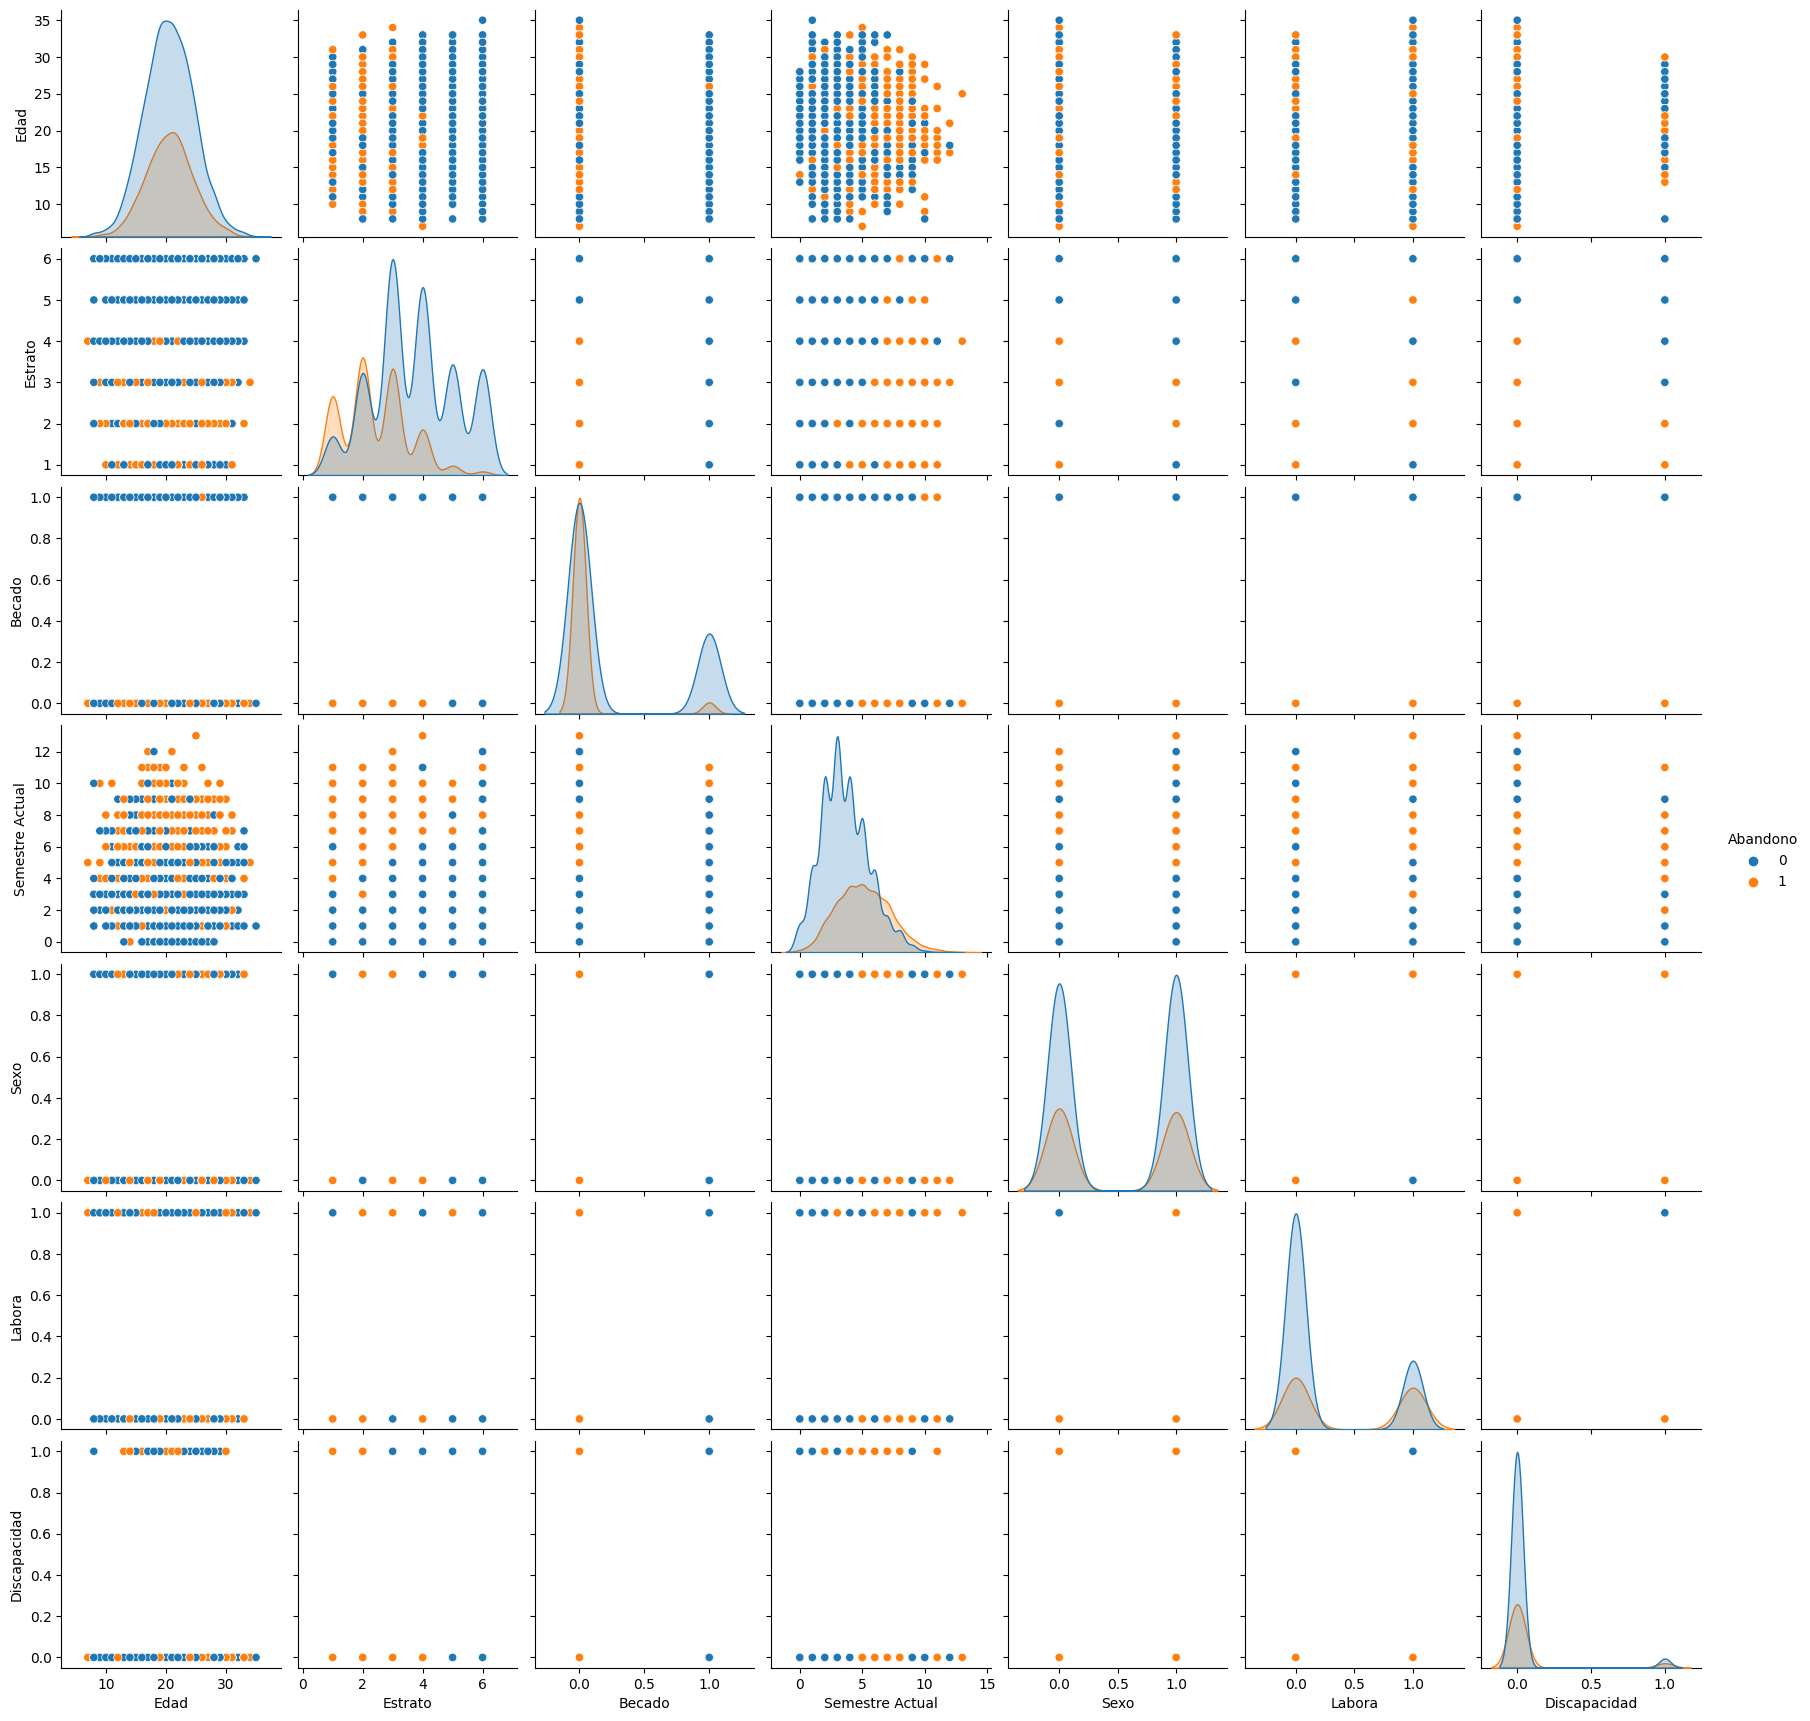

In [226]:
sb.pairplot(data=datos, hue='Abandono')

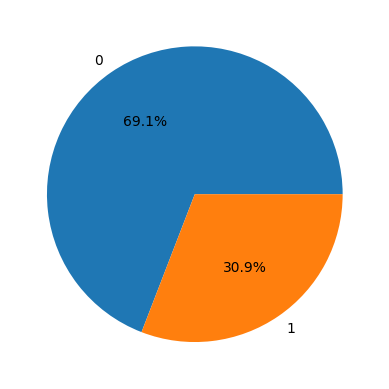

In [227]:
plt.pie(x=datos['Abandono'].value_counts(), labels=datos['Abandono'].value_counts().index, autopct='%0.1f%%')
plt.show()

In [228]:
datos_no = datos[datos['Abandono'] == 0]
datos_si = datos[datos['Abandono'] == 1]

datos_si_re = datos_si.sample(datos_no.shape[0], replace=True)

datos = pd.concat([datos_si_re, datos_no])
datos.describe()

,Edad,Estrato,Becado,Semestre Actual,Sexo,Labora,Discapacidad,Abandono
count,6222.000000,6222.000000,6222.000000,6222.000000,6222.000000,6222.000000,6222.000000,6222.00000
mean,20.564931,3.082610,0.166506,4.339119,0.498232,0.344262,0.054806,0.50000
std,3.963003,1.400481,0.372564,2.108779,0.500037,0.475165,0.227619,0.50004
min,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,18.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.00000
50%,21.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.50000
75%,23.000000,4.000000,0.000000,6.000000,1.000000,1.000000,0.000000,1.00000
max,35.000000,6.000000,1.000000,13.000000,1.000000,1.000000,1.000000,1.00000


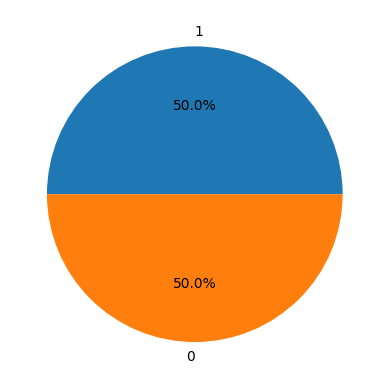

In [229]:
plt.pie(x=datos['Abandono'].value_counts(), labels=datos['Abandono'].value_counts().index, autopct='%0.1f%%')
plt.show()

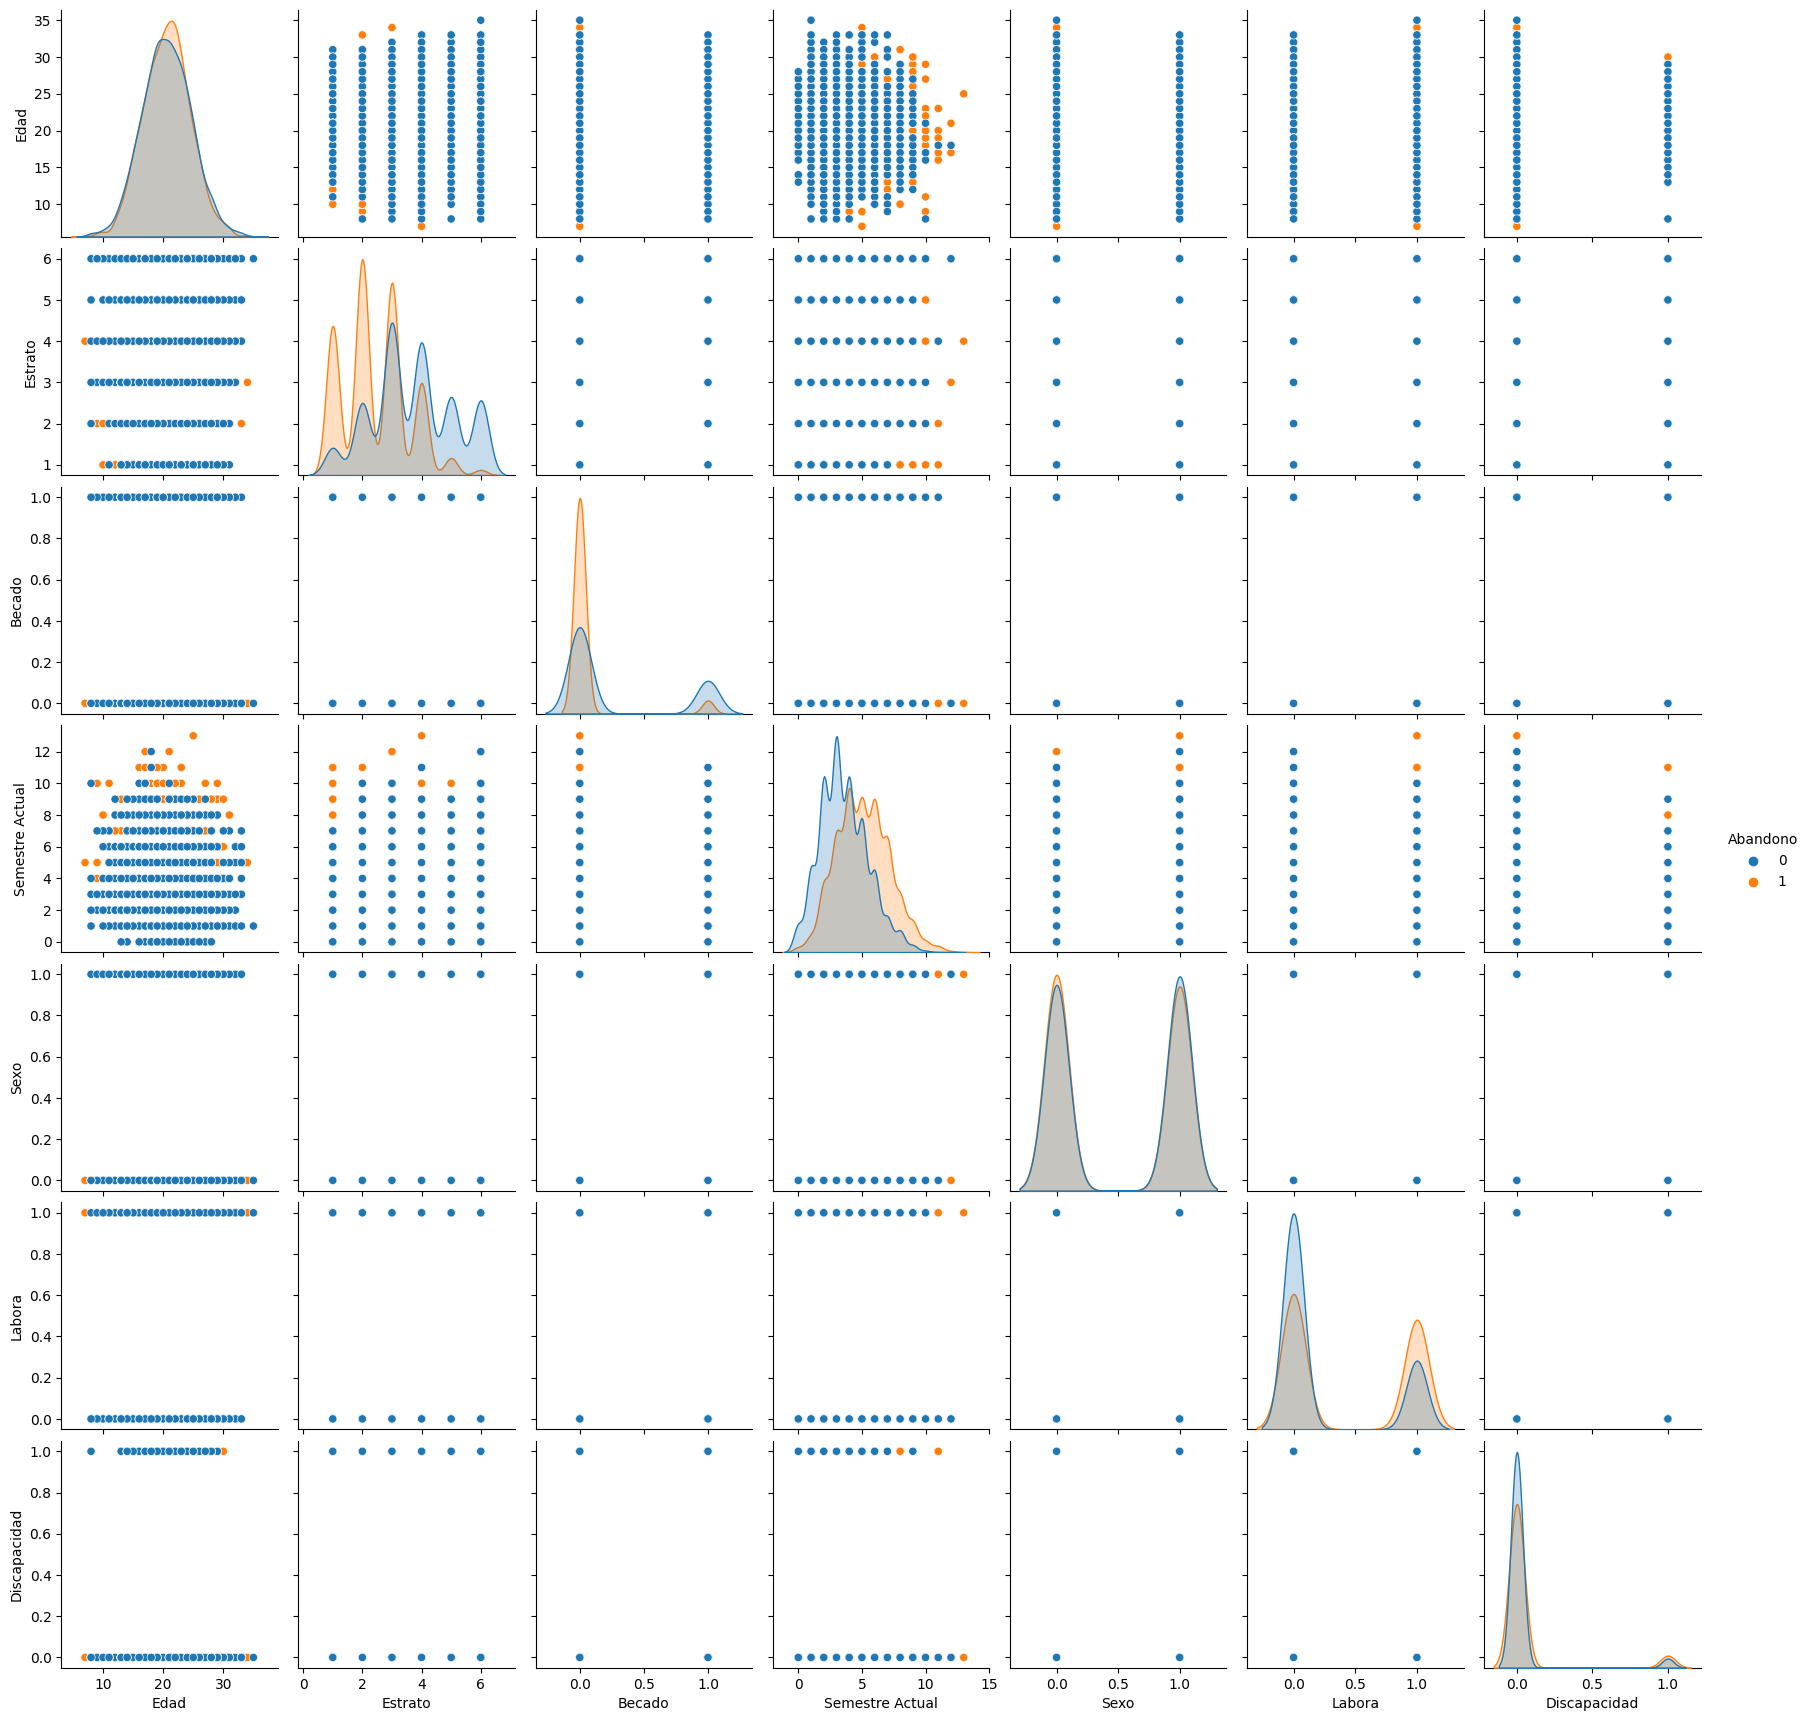

In [230]:
sb.pairplot(data=datos, hue='Abandono')

Text(0.5, 1.0, 'Count of Each Stratum')

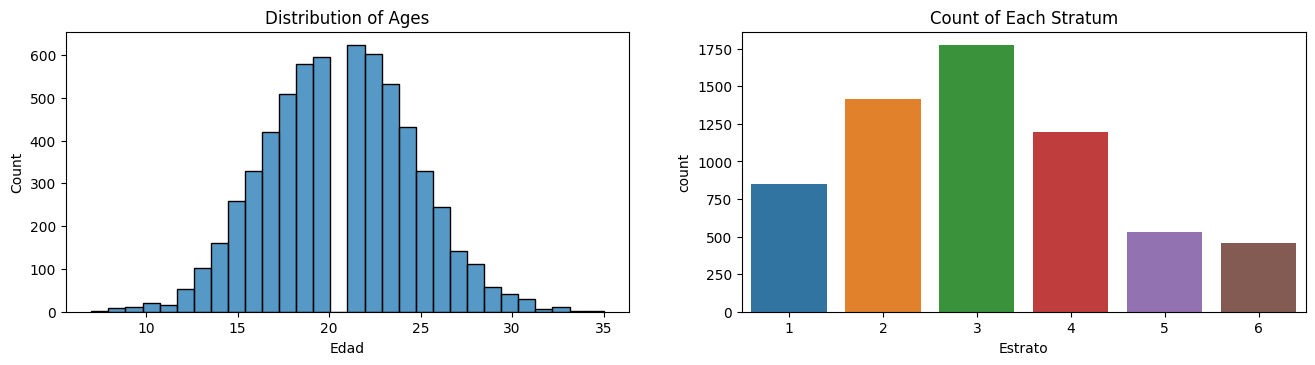

In [231]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
sb.histplot(datos['Edad'], kde=False, bins=30)
plt.title('Distribution of Ages')

plt.subplot(2, 2, 2)
sb.countplot(x='Estrato', data=datos)
plt.title('Count of Each Stratum')


Text(0.5, 1.0, 'Number of Students from different regions')

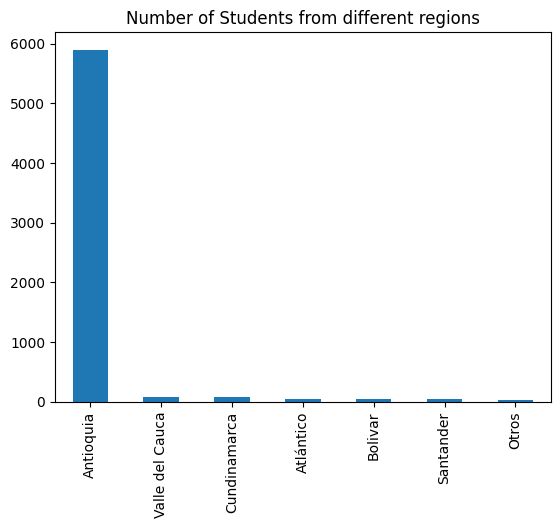

In [232]:
datos['Procedencia'].value_counts().plot(kind='bar')
plt.title('Number of Students from different regions')


Text(0.5, 1.0, 'Number of Students in Each Academic Program')

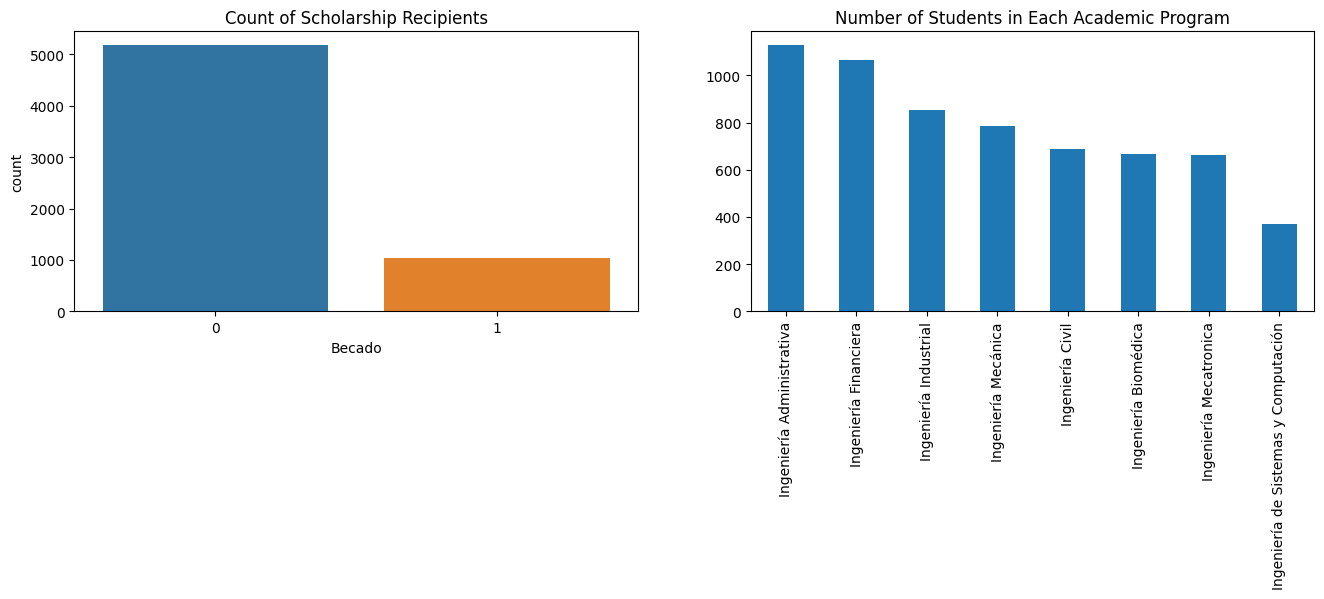

In [233]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 3)
sb.countplot(x='Becado', data=datos)
plt.title('Count of Scholarship Recipients')

plt.subplot(2, 2, 4)
datos['Programa Academico'].value_counts().plot(kind='bar')
plt.title('Number of Students in Each Academic Program')

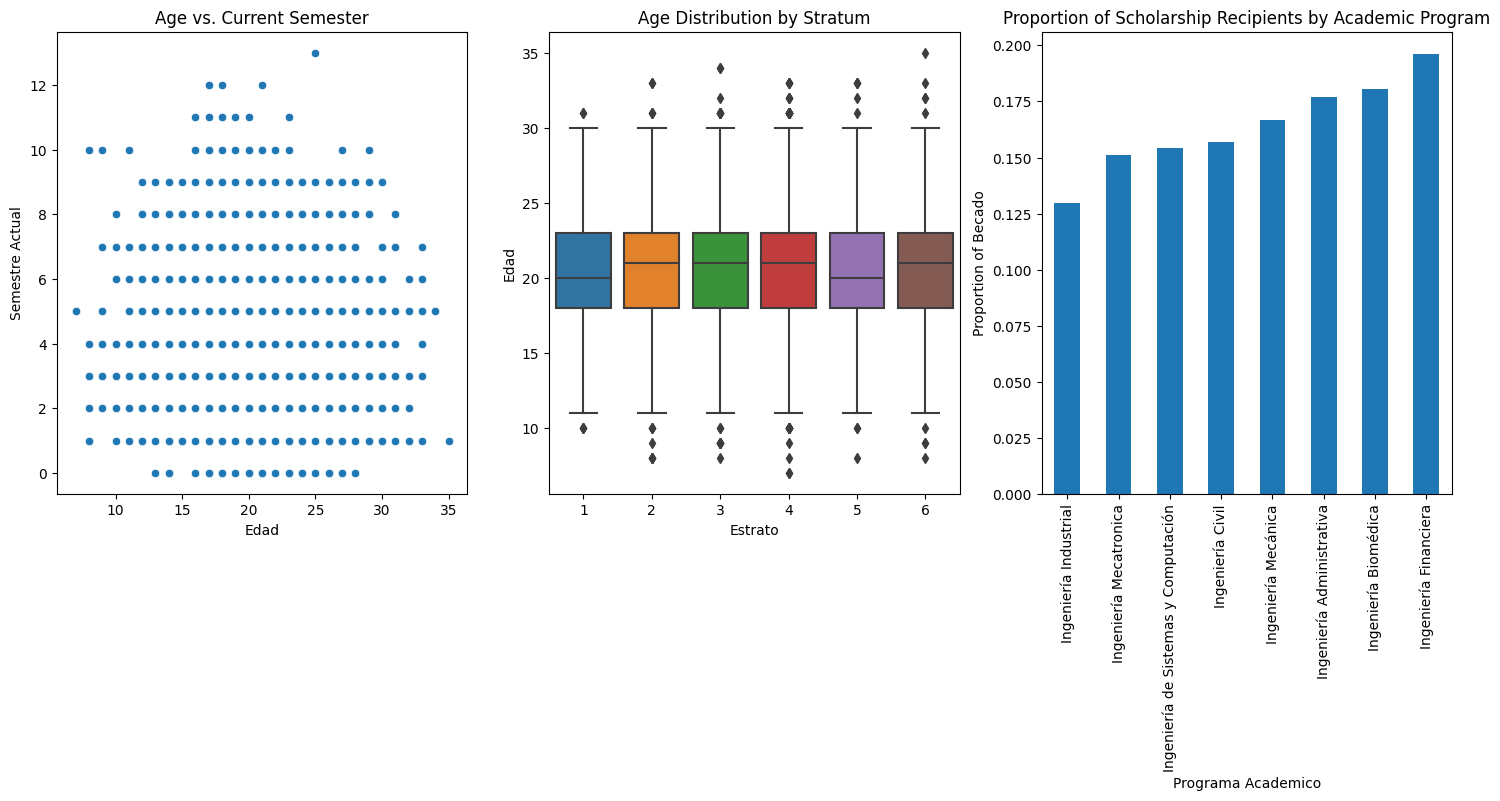

In [234]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sb.scatterplot(x='Edad', y='Semestre Actual', data=datos)
plt.title('Age vs. Current Semester')

plt.subplot(1, 3, 2)
sb.boxplot(x='Estrato', y='Edad', data=datos)
plt.title('Age Distribution by Stratum')

plt.subplot(1, 3, 3)
scholarship_by_program = datos.groupby('Programa Academico')['Becado'].mean().sort_values()
scholarship_by_program.plot(kind='bar')
plt.title('Proportion of Scholarship Recipients by Academic Program')
plt.ylabel('Proportion of Becado')

plt.show()

In [235]:
dropout_rate_by_stratum = datos.groupby('Estrato')['Abandono'].mean()
fig1 = dropout_rate_by_stratum.iplot(kind='bar', title='Dropout Rate by Socioeconomic Stratum', yTitle='Dropout Rate', xTitle='Socioeconomic Stratum', asFigure=True)

dropout_rate_by_program = datos.groupby('Programa Academico')['Abandono'].mean()
fig2 = dropout_rate_by_program.iplot(kind='bar', title='Dropout Rate by Academic Program', yTitle='Dropout Rate', xTitle='Academic Program', asFigure=True)

dropout_rate_by_semester = datos.groupby('Semestre Actual')['Abandono'].mean()
fig3 = dropout_rate_by_semester.iplot(kind='bar', title='Dropout Rate by Semester', yTitle='Dropout Rate', xTitle='Current Semester', asFigure=True)

dropout_age_distribution = datos[datos['Abandono'] == 1]['Edad']
fig4 = dropout_age_distribution.iplot(kind='histogram', title='Distribution of Age of Dropouts', yTitle='Frequency', xTitle='Age', bins=20, asFigure=True)


fig1.show()
fig2.show()
fig3.show()
fig4.show()

In [236]:
dropout_rate_by_gender = datos.groupby('Sexo')['Abandono'].mean()
dropout_rate_by_origin = datos.groupby('Procedencia')['Abandono'].mean()
dropout_rate_by_working_status = datos.groupby('Labora')['Abandono'].mean()
dropout_rate_by_scholarship_status = datos.groupby('Becado')['Abandono'].mean()
dropout_rate_by_program = datos.groupby('Programa Academico')['Abandono'].mean()

fig5_pie = px.pie(values=dropout_rate_by_gender.values, names=dropout_rate_by_gender.index, title='Dropout Rate by Gender')
fig6_pie = px.pie(values=dropout_rate_by_origin.values, names=dropout_rate_by_origin.index, title='Dropout Rate by Origin')
fig7_pie = px.pie(values=dropout_rate_by_working_status.values, names=dropout_rate_by_working_status.index, title='Dropout Rate among Working Students')
fig8_pie = px.pie(values=dropout_rate_by_scholarship_status.values, names=dropout_rate_by_scholarship_status.index, title='Dropout Rate among Scholarship Students')
fig9_pie = px.pie(values=dropout_rate_by_program.values, names=dropout_rate_by_program.index, title='Dropout Rate by Academic Program')

fig5_pie.show()
fig6_pie.show()
fig7_pie.show()
fig8_pie.show()
fig9_pie.show()

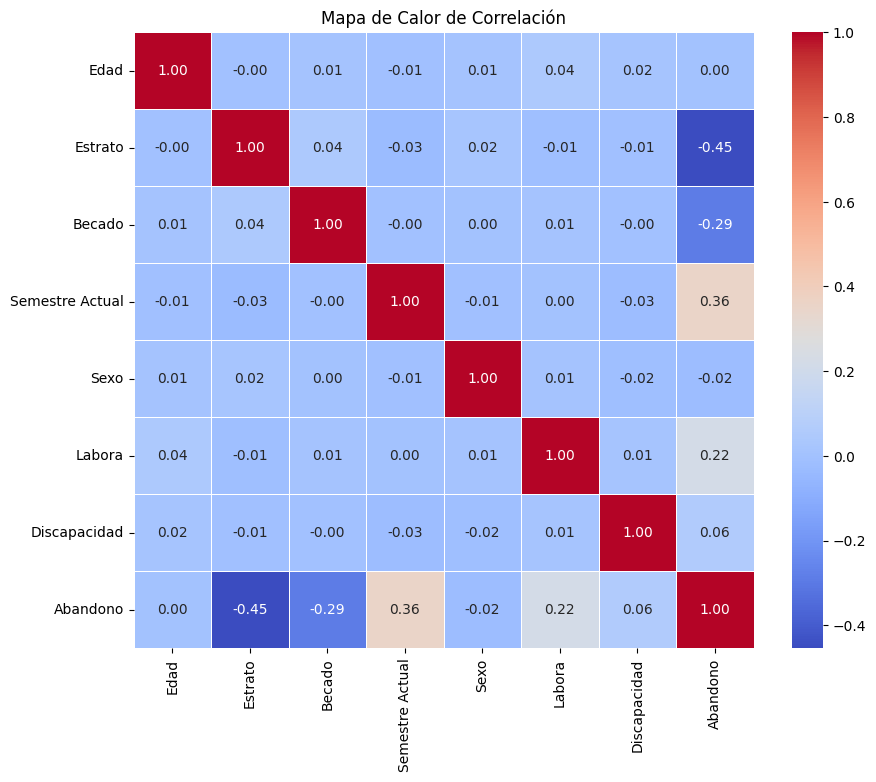

In [237]:
numeric_columns = datos.select_dtypes(include=['int64']).columns.to_list()

correlation_matrix = datos[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Calor de Correlación')
plt.show()

In [238]:
numCols = datos.drop('Abandono', axis=1).select_dtypes(include=['int64']).columns.to_list()
catCols = datos.select_dtypes(include = ['object']).columns.to_list()
yCols = datos[['Abandono']].columns.to_list()

numTransformer = Pipeline(steps=[('scaler', MinMaxScaler())])
catTransformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown = 'ignore'))])
yTransformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])

preprocesador = ColumnTransformer(transformers=[
    ('num', numTransformer, numCols),
    ('cat', catTransformer, catCols),
    ('one', yTransformer, yCols)
], remainder='passthrough')
set_config(display='diagram')
preprocesador

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['Edad', 'Estrato', 'Becado',
                                  'Semestre Actual', 'Sexo', 'Labora',
                                  'Discapacidad']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Programa Academico', 'Procedencia']),
                                ('one',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Abandono'])])

In [239]:
datosPre = preprocesador.fit_transform(datos)
codCat = preprocesador.named_transformers_['cat']['onehot'].get_feature_names_out(catCols)
labels = np.concatenate([numCols, codCat, yCols])
datosPro = pd.DataFrame(datosPre, columns=labels)
datosPro.head()

,Edad,Estrato,Becado,Semestre Actual,Sexo,Labora,Discapacidad,Programa Academico_Ingeniería Administrativa,Programa Academico_Ingeniería Biomédica,Programa Academico_Ingeniería Civil,...,Programa Academico_Ingeniería Mecánica,Programa Academico_Ingeniería de Sistemas y Computación,Procedencia_Antioquia,Procedencia_Atlántico,Procedencia_Bolivar,Procedencia_Cundinamarca,Procedencia_Otros,Procedencia_Santander,Procedencia_Valle del Cauca,Abandono
0,0.250000,0.6,0.0,0.153846,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.607143,0.6,0.0,0.538462,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.357143,0.4,0.0,0.461538,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.678571,0.0,0.0,0.538462,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.321429,0.4,0.0,0.230769,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [240]:
X = datosPro.drop('Abandono', axis=1)
y = datosPro[['Abandono']]

In [241]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.750, random_state=12)

In [242]:
modelo_1 = LogisticRegression()
modelo_1.fit(x_train, y_train)

LogisticRegression()

In [243]:
hiper_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'None'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky', 'saga']
}

In [244]:
classifier = GridSearchCV(estimator=modelo_1, param_grid=hiper_grid, cv=5)
classifier.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', 'None'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cholesky',
                                    'saga']})

In [245]:
validation = pd.concat([pd.DataFrame(classifier.cv_results_['params']), pd.DataFrame(classifier.cv_results_['mean_test_score'], columns=[ 'Accuracy'])], axis=1)
validation.sort_values('Accuracy', ascending=False)

,C,penalty,solver,Accuracy
65,1.0,l1,liblinear,0.878912
67,1.0,l1,saga,0.878698
68,1.0,l2,lbfgs,0.878484
69,1.0,l2,liblinear,0.878484
70,1.0,l2,newton-cholesky,0.878484
...,...,...,...,...
107,100.0,elasticnet,saga,NaN
108,100.0,None,lbfgs,NaN
109,100.0,None,liblinear,NaN
110,100.0,None,newton-cholesky,NaN


In [246]:
modelo_1_final = classifier.best_estimator_
modelo_1_final

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [247]:
y_pred_test_final_1 = modelo_1_final.predict(x_test)
accuracy_test_final_1 = accuracy_score(y_test, y_pred_test_final_1)
matrix_test_final_1 = confusion_matrix(y_test, y_pred_test_final_1)
f1_test_final_1 = f1_score(y_test, y_pred_test_final_1, average = 'weighted')

accuracy de la regresión logística final es  0.8952442159383034
f1_score de la regresión logística final es  0.8952627859211848


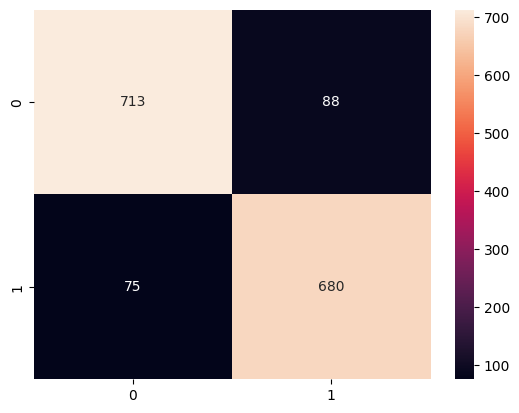

In [248]:
print(f'accuracy de la regresión logística final es  {accuracy_test_final_1}')
print(f'f1_score de la regresión logística final es  {f1_test_final_1}')
sb.heatmap(matrix_test_final_1, annot =True, fmt = 'd')
plt.show()

In [249]:
modelo_2 = SVC()
hiper_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
    'degree' : [2, 3, 4, 5]
}

In [250]:
classifier = GridSearchCV(estimator=modelo_2, param_grid=hiper_grid, cv=3)
classifier.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'degree': [2, 3, 4, 5],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [251]:
validation = pd.concat([pd.DataFrame(classifier.cv_results_['params']), pd.DataFrame(classifier.cv_results_['mean_test_score'], columns=[ 'Accuracy'])], axis=1)
validation.sort_values('Accuracy', ascending=False)

,C,degree,kernel,Accuracy
106,100.0000,4,rbf,0.879556
98,100.0000,2,rbf,0.879556
102,100.0000,3,rbf,0.879556
110,100.0000,5,rbf,0.879556
88,10.0000,4,linear,0.879342
...,...,...,...,...
23,0.0010,3,sigmoid,0.504929
26,0.0010,4,rbf,0.504929
27,0.0010,4,sigmoid,0.504929
30,0.0010,5,rbf,0.504929


In [252]:
modelo_2_final = classifier.best_estimator_
modelo_2_final

SVC(C=100, degree=2)

accuracy de SVC final es  0.8952442159383034
f1_score de SVC final es  0.8952497974283052


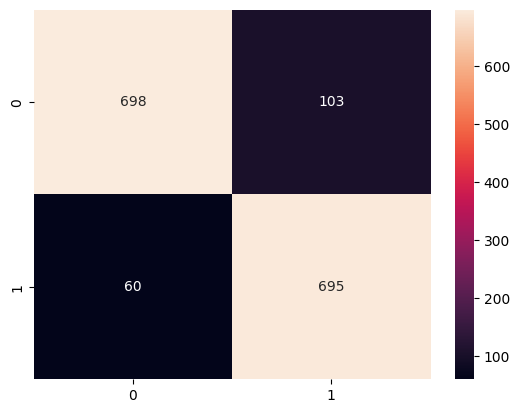

In [253]:
y_pred_test_final_2 = modelo_2_final.predict(x_test)
accuracy_test_final_2 = accuracy_score(y_test, y_pred_test_final_2)
matrix_test_final_2 = confusion_matrix(y_test, y_pred_test_final_2)
f1_test_final_2 = f1_score(y_test, y_pred_test_final_2, average = 'weighted')
print(f'accuracy de SVC final es  {accuracy_test_final_2}')
print(f'f1_score de SVC final es  {f1_test_final_2}')
sb.heatmap(matrix_test_final_2, annot=True, fmt='d')
plt.show()

In [254]:
modelo_3 = DecisionTreeClassifier()
hiper_grid = {
    'criterion' : ['log_loss', 'gini', 'entropy'],
    'max_depth' : [5, 15, 20, 25, 30],
    'min_samples_split' : [2, 3, 4, 5, 10],
    'max_leaf_nodes' : [None, 10, 12, 15]
}

In [255]:
classifier = GridSearchCV(estimator=modelo_3, param_grid=hiper_grid, cv=3)
classifier.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['log_loss', 'gini', 'entropy'],
                         'max_depth': [5, 15, 20, 25, 30],
                         'max_leaf_nodes': [None, 10, 12, 15],
                         'min_samples_split': [2, 3, 4, 5, 10]})

In [256]:
validation = pd.concat([pd.DataFrame(classifier.cv_results_['params']), pd.DataFrame(classifier.cv_results_['mean_test_score'], columns=[ 'Accuracy'])], axis=1)
validation.sort_values('Accuracy', ascending=False)

,criterion,max_depth,max_leaf_nodes,min_samples_split,Accuracy
180,gini,30,NaN,2,0.878055
140,gini,20,NaN,2,0.877628
120,gini,15,NaN,2,0.876985
160,gini,25,NaN,2,0.876128
121,gini,15,NaN,3,0.874628
...,...,...,...,...,...
268,entropy,25,10.0,5,0.761251
269,entropy,25,10.0,10,0.761251
229,entropy,15,10.0,10,0.761251
65,log_loss,25,10.0,2,0.761251


In [257]:
modelo_3_final = classifier.best_estimator_
modelo_3_final

DecisionTreeClassifier(max_depth=30)

In [258]:
y_pred_test_final_3 = modelo_3_final.predict(x_test)
accuracy_test_final_3 = accuracy_score(y_test, y_pred_test_final_3)
matrix_test_final_3 = confusion_matrix(y_test, y_pred_test_final_3)
f1_test_final_3 = f1_score(y_test, y_pred_test_final_3, average='weighted')

accuracy de decision tree final es  0.8984575835475579
f1_score de decision tree final es  0.898422351104862


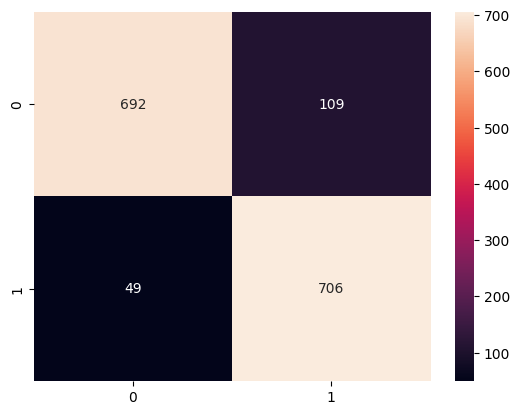

In [259]:
print(f'accuracy de decision tree final es  {accuracy_test_final_3}')
print(f'f1_score de decision tree final es  {f1_test_final_3}')
sb.heatmap(matrix_test_final_3, annot=True, fmt='d')
plt.show()

In [260]:
modelo_4 =  RandomForestClassifier(random_state=16)
hiper_grid = { 
    'n_estimators' : [100, 200, 300, 400, 500],
    'criterion' : ['log_loss', 'gini', 'entropy'],
    'max_depth' : [5, 20, 30],
    'min_samples_split' : [2, 4, 6],
    'max_leaf_nodes' : [None, 10, 12, 15],
}

In [261]:
classifier = GridSearchCV(estimator=modelo_4, param_grid=hiper_grid, cv=3)
classifier.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=16),
             param_grid={'criterion': ['log_loss', 'gini', 'entropy'],
                         'max_depth': [5, 20, 30],
                         'max_leaf_nodes': [None, 10, 12, 15],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [262]:
validation = pd.concat([pd.DataFrame(classifier.cv_results_['params']), pd.DataFrame(classifier.cv_results_['mean_test_score'], columns=[ 'Accuracy'])], axis=1)
validation.sort_values('Accuracy', ascending=False)

,criterion,max_depth,max_leaf_nodes,min_samples_split,n_estimators,Accuracy
121,log_loss,30,NaN,2,200,0.901844
481,entropy,30,NaN,2,200,0.901844
120,log_loss,30,NaN,2,100,0.901415
480,entropy,30,NaN,2,100,0.901415
64,log_loss,20,NaN,2,500,0.901201
...,...,...,...,...,...,...
380,entropy,5,10.0,4,100,0.842693
15,log_loss,5,10.0,2,100,0.842693
375,entropy,5,10.0,2,100,0.842693
385,entropy,5,10.0,6,100,0.841836


In [263]:
modelo_4_final = classifier.best_estimator_
modelo_4_final

RandomForestClassifier(criterion='log_loss', max_depth=30, n_estimators=200,
                       random_state=16)

In [264]:
y_pred_test_final_4 = modelo_4_final.predict(x_test)
accuracy_test_final_4 = accuracy_score(y_test, y_pred_test_final_4)
matrix_test_final_4 = confusion_matrix(y_test, y_pred_test_final_4)
f1_test_final_4 = f1_score(y_test, y_pred_test_final_4, average='weighted')

accuracy de random forest final es  0.9196658097686375
f1_score de random forest final es  0.9196573486867173


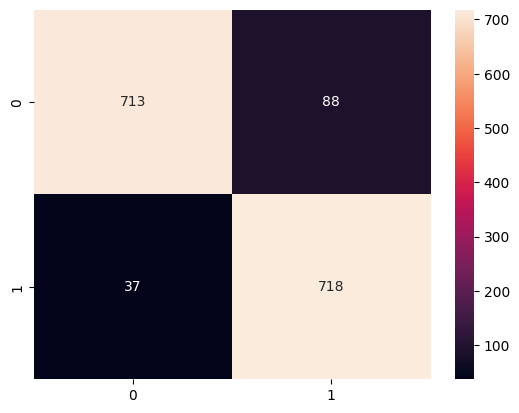

In [265]:
print(f'accuracy de random forest final es  {accuracy_test_final_4}')
print(f'f1_score de random forest final es  {f1_test_final_4}')
sb.heatmap(matrix_test_final_4, annot=True, fmt='d')
plt.show()

In [266]:
modelo_5 = AdaBoostClassifier(random_state=16)
hiper_grid = { 
    'n_estimators' : [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 1.0]
}

In [267]:
classifier = GridSearchCV(estimator=modelo_5, param_grid=hiper_grid, cv=3)
classifier.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=16),
             param_grid={'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [268]:
validation = pd.concat([pd.DataFrame(classifier.cv_results_['params']), pd.DataFrame(classifier.cv_results_['mean_test_score'], columns=[ 'Accuracy'])], axis=1)
validation.sort_values('Accuracy', ascending=False)

,learning_rate,n_estimators,Accuracy
7,0.10,300,0.875269
10,1.00,100,0.874198
8,0.10,400,0.874197
13,1.00,400,0.873341
14,1.00,500,0.873341
11,1.00,200,0.873340
12,1.00,300,0.872912
9,0.10,500,0.872483
6,0.10,200,0.869910
5,0.10,100,0.852765


In [269]:
modelo_5_final = classifier.best_estimator_
modelo_5_final

AdaBoostClassifier(learning_rate=0.1, n_estimators=300, random_state=16)

In [270]:
y_pred_test_final_5 = modelo_5_final.predict(x_test)
accuracy_test_final_5 = accuracy_score(y_test, y_pred_test_final_5)
matrix_test_final_5 = confusion_matrix(y_test, y_pred_test_final_5)
f1_test_final_5 = f1_score(y_test, y_pred_test_final_5, average='weighted')

accuracy de adaboost final es  0.8849614395886889
f1_score de adaboost final es  0.8849863910325022


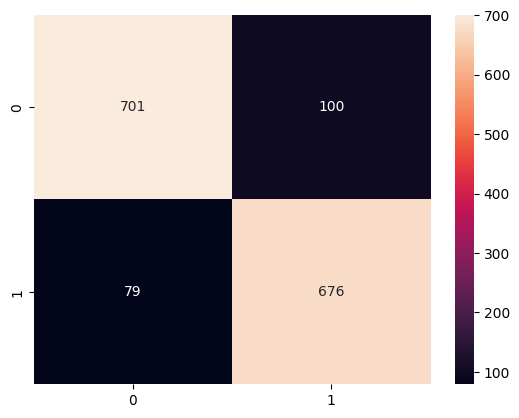

In [271]:
print(f'accuracy de adaboost final es  {accuracy_test_final_5}')
print(f'f1_score de adaboost final es  {f1_test_final_5}')
sb.heatmap(matrix_test_final_5, annot=True, fmt='d')
plt.show()